# Introduction

This notebook is a 'quick-start' for the [CGIAR Crop Yield Prediction Challenge](https://zindi.africa/competitions/cgiar-crop-yield-prediction-challenge). We'll take a look at the data, fit a quick model and make a submission, with hints at each stage for extra options to investigate.

Let's dive in!

# Loading the data

The data isn't a simple table - instead we must read the inputs from individual .npy files. Here we'll load the dataframes, open a file or two and take a look at the format.

In [77]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [78]:
# Train.csv has the Field_IDs needed to find the npy files
train = pd.read_csv('Train.csv')
print(train.shape)
train.head()

(2977, 4)


,Field_ID,Year,Quality,Yield
0,MH2O0YH,2019,3,3.686
1,O9TURWL,2019,2,5.657
2,35AFSDD,2019,3,3.082
3,PM05EG9,2019,2,2.707
4,V7PZBCG,2019,2,2.679


In [79]:
train['Quality'].value_counts()

3    1321
2    1231
1     425
Name: Quality, dtype: int64

In [80]:
#remove low quality 
train = train[train.Quality > 1]
train['Quality'].value_counts()

3    1321
2    1231
Name: Quality, dtype: int64

Loading image_arrays_train/OYENPP2.npy as an array
Array shape: (360, 42, 41)


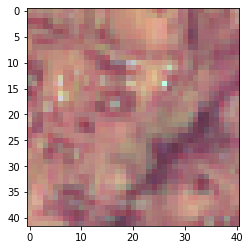

In [81]:
# Look at a sample:
fid = train['Field_ID'].sample().values[0]
fn = f'image_arrays_train/{fid}.npy' # File name based on Field_ID
print(f'Loading {fn} as an array')
arr = np.load(fn) # Loading the data with numpy
print('Array shape:', arr.shape) # 360 bands, images 40 or 41px a side
rgb_jan = np.stack([arr[4], arr[3], arr[2]], axis=-1) # Combine three bands for viewing
rgb_jan = rgb_jan / np.max(rgb_jan) # Scale band values to (0, 1) for easy image display
plt.imshow(rgb_jan) # View with matplotlib

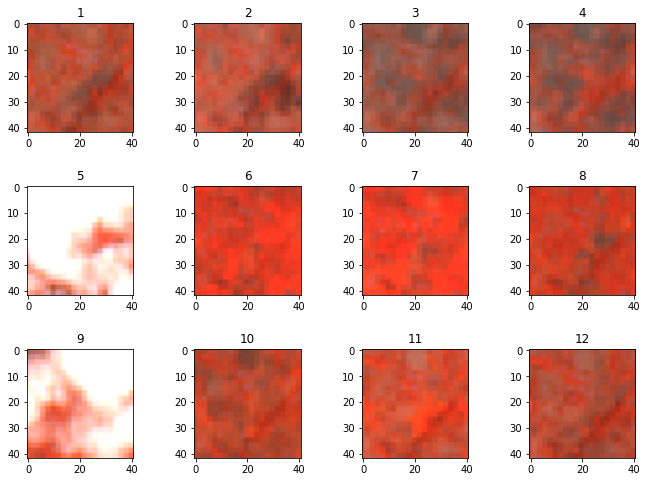

In [82]:
# View false colour images from each month in the year:
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
    rgb = np.stack([arr[i*30 + 8], arr[i*30 + 4], arr[i*30 + 3]], axis=-1) # False colour (band 8, 4 and 3)
    rgb = rgb / 4000 # Scaling consistently 
    axs[i].imshow(rgb.clip(0, 1))
    axs[i].set_title(str(i+1))

What's with the white fluffy stuff? These are clouds - the bane of all remote sensing analysts...

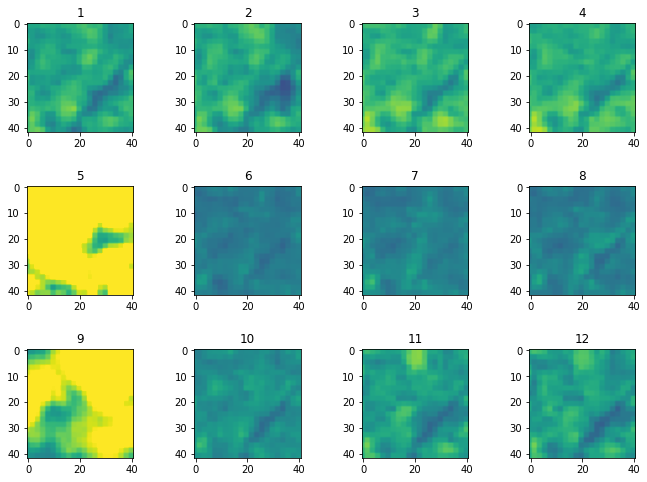

In [83]:
# Show the SWIR band (B12) where clouds have a high reflectance
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
    cloud = arr[i*30 + 11]
    axs[i].imshow(cloud, vmin=0, vmax=4000)
    axs[i].set_title(str(i+1))

# Sampling from the images

There are some hard-coded band indexes in the examples above that won't have made sense - how did we know which bands were which?
There are 30 bands for each month. You can see the full list of bands with:

In [84]:
band_names = [l.strip() for l in open('bandnames.txt', 'r').readlines()]
#print(band_names)

0_S2_B1 is band one from the Sentinel 2 image for January (month 0). They're ordered, so we know that the first image band in the array is 0_S2_B1...

You'll likely want to examine specific bands. Here's an example where we create a function to sample the center point (20, 20) for specified bands from each month:

In [270]:
def process_im(fid, folder='image_arrays_train'):
    fn = f'{folder}/{fid}.npy'
    arr = np.load(fn)
    bands_of_interest = ['S2_B5', 'S2_B4', 'S2_B3', 'S2_B2', 'CLIM_pr', 'CLIM_soil']
    values = {}
    for month in range(12):
        bns = [str(month) + '_' + b for b in bands_of_interest] # Bands of interest for this month 
        idxs = np.where(np.isin(band_names, bns)) # Index of these bands
        vs = arr[idxs, 20, 20] # Sample the im at the center point
        for bn, v in zip(bns, vs[0]):
            values[bn] = v
    return values

# Example
#process_im('35AFSDD')

In [271]:
ss = pd.read_csv('SampleSubmission.csv')

With this, we can sample the inputs for each field in train and use that to build a dataframe of input features:

So far, we process data by removing Quality = 1 and outliers

In [272]:
# The following two blocks are not going to be used.

In [273]:
def image_get(fid, band_index = 1,folder='image_arrays_train'):
    fn = f'{folder}/{fid}.npy'
    arr = np.load(fn) # Loading the data with numpy  
    return arr[band_index].flatten()[0:40**2]

#X_train = [image_get(fid) for fid in train['Field_ID'].values]
#y_train = [val for val in train['Yield'].values]

#X_test = [image_get(fid,'image_arrays_test') for fid in train['Field_ID'].values]
#y_test = [val for val in test['Yield'].values]
#X_train = np.array(X_train)
#y_train = np.array(y_train)

In [274]:
"""
for i in range(len(X_train)):
    X_train[i] = X_train[i].astype(np.int32)
print(X_train.dtype,len(X_train),X_train[0].dtype)
"""

'\nfor i in range(len(X_train)):\n    X_train[i] = X_train[i].astype(np.int32)\nprint(X_train.dtype,len(X_train),X_train[0].dtype)\n'

In [275]:
use_gpu = torch.cuda.is_available()
print(use_gpu) #Runn the following with GPU cuda

True


In [360]:
import torch.nn.functional as F
#This CNN class can be modified to increase performance.
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(                  
                in_channels=360,  #input size: (360,9,9)
                out_channels=180,#size after conv: (16,9,9)        
                kernel_size=5,      
                padding=2
            ),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels = 180,#(16,3,3) 
                out_channels = 90,#(32,3,3)
                kernel_size = 5,
                padding = 2
            ),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels = 90,#(16,3,3) 
                out_channels = 50,#(32,3,3)
                kernel_size = 5,
                padding = 2
            ),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels = 50,#(16,3,3) 
                out_channels = 16,#(32,3,3)
                kernel_size = 5,
                padding = 2
            ),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(
                in_channels = 16,#(16,3,3) 
                out_channels = 16,#(32,3,3)
                kernel_size = 5,
                padding = 2
            ),
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(
                in_channels = 16,#(16,3,3) 
                out_channels = 16,#(32,3,3)
                kernel_size = 5,
                padding = 2
            ),
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(
                in_channels = 16,#(16,3,3) 
                out_channels = 16,#(32,3,3)
                kernel_size = 5,
                padding = 2
            ),
        )
        self.conv8 = nn.Sequential(
            nn.Conv2d(
                in_channels = 16,#(16,3,3) 
                out_channels = 16,#(32,3,3)
                kernel_size = 5,
                padding = 2
            ),
        )
        self.conv9 = nn.Sequential(
            nn.Conv2d(
                in_channels = 16,#(16,3,3) 
                out_channels = 16,#(32,3,3)
                kernel_size = 5,
                padding = 2
            ),
        )
        self.conv10 = nn.Sequential(
            nn.Conv2d(
                in_channels = 16,#(16,3,3) 
                out_channels = 16,#(32,3,3)
                kernel_size = 5,
                padding = 2
            ),
        )
        self.conv11= nn.Sequential(
            nn.Conv2d(
                in_channels = 16,#(16,3,3) 
                out_channels = 16,#(32,3,3)
                kernel_size = 5,
                padding = 2
            ),
        )
        self.conv12 = nn.Sequential(
            nn.Conv2d(
                in_channels = 16,#(16,3,3) 
                out_channels = 16,#(32,3,3)
                kernel_size = 5,
                padding = 2
            ),
        )
        self.conv13 = nn.Sequential(
            nn.Conv2d(
                in_channels = 16,#(16,3,3) 
                out_channels = 16,#(32,3,3)
                kernel_size = 5,
                padding = 2
            ),
        )
        self.conv14 = nn.Sequential(
            nn.Conv2d(
                in_channels = 16,#(16,3,3) 
                out_channels = 16,#(32,3,3)
                kernel_size = 5,
                padding = 2
            ),
        )
        self.conv15 = nn.Sequential(
            nn.Conv2d(
                in_channels = 16,#(16,3,3) 
                out_channels = 16,#(32,3,3)
                kernel_size = 5,
                padding = 2
            ),
        )
        self.conv16 = nn.Sequential(
            nn.Conv2d(
                in_channels = 16,#(16,3,3) 
                out_channels = 16,#(32,3,3)
                kernel_size = 5,
                padding = 2
            ),
        )
        self.conv17 = nn.Sequential(
            nn.Conv2d(
                in_channels = 16,#(16,3,3) 
                out_channels = 16,#(32,3,3)
                kernel_size = 5,
                padding = 2
            ),
        )
        self.conv18 = nn.Sequential(
            nn.Conv2d(
                in_channels = 16,#(16,3,3) 
                out_channels = 16,#(32,3,3)
                kernel_size = 5,
                padding = 2
            ),
        )
        self.conv19 = nn.Sequential(
            nn.Conv2d(
                in_channels = 16,#(16,3,3) 
                out_channels = 16,#(32,3,3)
                kernel_size = 5,
                padding = 2
            ),
        )
        self.conv20 = nn.Sequential(
            nn.Conv2d(
                in_channels = 16,#(16,3,3) 
                out_channels = 16,#(32,3,3)
                kernel_size = 5,
                padding = 2
            ),
        )
        
        self.out = nn.Linear(16*9*9,1)
        
    
    def forward(self,x):
        x = F.relu(self.conv1(x))                     
        x = F.relu(self.conv2(x)) 
        x = F.relu(self.conv3(x)) 
        x = F.relu(self.conv4(x)) 
        x = F.relu(self.conv5(x)) 
        x = F.relu(self.conv6(x)) 
        x = F.relu(self.conv7(x)) 
        x = F.relu(self.conv8(x)) 
        x = F.relu(self.conv9(x)) 
        x = F.relu(self.conv10(x))
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.relu(self.conv13(x))
        x = F.relu(self.conv14(x))
        x = F.relu(self.conv15(x))
        x = F.relu(self.conv16(x))
        x = F.relu(self.conv17(x))
        x = F.relu(self.conv18(x))
        x = F.relu(self.conv19(x))
        x = self.conv20(x)
        x = x.view(x.size(0),-1)              
        out = self.out(x)                     
        return out


In [361]:
#check cnn configuration
cnn = CNN()
cnn.cuda() # delete this line if using cup
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(360, 180, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (conv2): Sequential(
    (0): Conv2d(180, 90, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (conv3): Sequential(
    (0): Conv2d(90, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (conv4): Sequential(
    (0): Conv2d(50, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (conv5): Sequential(
    (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (conv6): Sequential(
    (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (conv7): Sequential(
    (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (conv8): Sequential(
    (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (conv9): Sequential(
    (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (conv10): Sequential(
    (0): Conv2d(16, 16, kernel_size=(5, 5), stride

In [362]:
# This load function is loading a certain field with all bands and month
# Return the middle 9*9 submatrix in int32 dtype
def get_image_center(fid, folder='image_arrays_train'):
    fn = f'{folder}/{fid}.npy'
    arr = np.load(fn) # Loading the data with numpy  
    arr_center = arr[:,17:26,17:26] #360 * 9 * 9matrix
    return arr_center.view('int32')


#looading train data and target
X_train = [get_image_center(fid) for fid in train['Field_ID'].values]
y_train = [val for val in train['Yield'].values]
#convert our training set
X = torch.Tensor([each for each in X_train])
y = torch.Tensor(y_train)
#set input and output for test
inputs = Variable(X)
outputs = Variable(y)

In [363]:
#convert our training set
X = torch.Tensor([each for each in X_train])
y = torch.Tensor(y_train)

In [364]:
inputs = Variable(X)
outputs = Variable(y)

In [366]:
import time
EPOCH = 1000
LR = 0.01

loss_func = nn.MSELoss() # this is for regression mean squared loss
optimizer = torch.optim.Adam(cnn.parameters(), lr = LR)
"""
#  this for  loop is combined with dataloader, but not working, so ignore this
for epoch in range(EPOCH): 
    for step, (x,y) in enumerate(loader):
        b_x = Variable(x)
        b_y = Variable(y)
        output = cnn(b_x)
        loss = loss_func(output,b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
"""

start = time.time()
#simple cnn training
for epoch in range(EPOCH): 
    pred_y = cnn(inputs.cuda()) # original: pred_y = cnn(inputs)
    loss = loss_func(pred_y[:,0],outputs.cuda())# original: loss = loss_func(pred_y[:,0],outputs.cuda())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1)%50 == 0: 
        print(epoch+1,loss)
end = time.time()
print("Time used ",end - start)

50 tensor(2.9911, device='cuda:0', grad_fn=<MseLossBackward>)
100 tensor(2.9661, device='cuda:0', grad_fn=<MseLossBackward>)
150 tensor(2.9660, device='cuda:0', grad_fn=<MseLossBackward>)
200 tensor(2.9660, device='cuda:0', grad_fn=<MseLossBackward>)
250 tensor(2.9660, device='cuda:0', grad_fn=<MseLossBackward>)
300 tensor(2.9660, device='cuda:0', grad_fn=<MseLossBackward>)
350 tensor(2.9660, device='cuda:0', grad_fn=<MseLossBackward>)
400 tensor(2.9660, device='cuda:0', grad_fn=<MseLossBackward>)
450 tensor(2.9660, device='cuda:0', grad_fn=<MseLossBackward>)
500 tensor(2.9660, device='cuda:0', grad_fn=<MseLossBackward>)
550 tensor(2.9660, device='cuda:0', grad_fn=<MseLossBackward>)
600 tensor(2.9660, device='cuda:0', grad_fn=<MseLossBackward>)
650 tensor(2.9660, device='cuda:0', grad_fn=<MseLossBackward>)
700 tensor(2.9660, device='cuda:0', grad_fn=<MseLossBackward>)
750 tensor(2.9660, device='cuda:0', grad_fn=<MseLossBackward>)
800 tensor(2.9660, device='cuda:0', grad_fn=<MseLossBack

# Saving Preds

Once we're happy with how we generate our inputs, we must process the test fields in the same way and save predictions. Here it is, condensed. Note the Field_IDs from the sample submission are used, and the same `process_im` function prepares the inputs, this time looking for .npy files in the 'image_arrays_test' folder. 

In [ ]:
# Load the sample submission file
ss = pd.read_csv('SampleSubmission.csv')

# Prep the data, using the same method we did for train
test_sampled = pd.DataFrame([process_im(fid, folder='image_arrays_test') for fid in ss['Field_ID'].values])

# Get model predictions
preds = model.predict(test_sampled)

# Store them in the submission dataframe and save
ss['Yield'] = preds
ss.to_csv('Sub.csv', index=False)
ss.head()

You can submit the Sub.csv file generated here on Zindi. This example scores ~2 (not as good as our score on our local test set, because the fields are more geographically separated). Now let's chat about ways to make this better:

# Improvements


1.   For the example above I chose the 'bands of interest' fairly randomly. A bit of research into which Sentinel 2 bands are used in this kind of task and what the different climate variables are should help make more informed choices there.
2.   We looked at all 12 months. Maize is normally planted just before the March-May rainy season (I think?) and harvested a few months later. Choose which months you'll prioritise to cut down on less useful data
3.   We looked at only the center pixel. Can you use a wider area to get better features? What about finding which pixels are most likely fields and sampling those?
4.   We did no model tuning, so obviously lots of fun to be had there
5.   Low-quality locations are often not fields - leave these out of your training set for better results. There are no low-quality (Quality=1) fields in the test set.
6.   Common measures such as NDVI, EVI etc can be computed by combining different bands. Look up how these vegetative indices are calculated for sentinel 2 and see if you can add those as features.
6.   ... As always, be creative - I'm sure there are lots more improvements to be made



In [ ]:
for col in train.columns: 
    print(col) 